# DINGO Tutorial

**Welcome to the DINGO tutorial!**

This notebook provides an introduction to the `dingo` machine-learning package for gravitational wave parameter estimation. It shows how to train a DINGO model from scratch or use an already-trained model to obtain posterior samples for gravitational wave events. We hope that this will serve as a starting point for those interested in using DINGO.

For a more general introduction to neural posterior estimation of gravitational waves (without DINGO), see the tutorial ["GW Parameter Inference with Machine Learning"](https://github.com/stephengreen/gw-school-corfu-2023).

Since it takes several days to train a production-level DINGO model [14 parameters, O(100 million) network parameters, O(10 million) training examples], we make several simplifications:
- Restrict the parameter space to two parameters (chirp mass and the mass ratio).
- Use a much smaller network and training dataset.
This will give reduced performance compared to the full model, but can be run in real time.

## Tutorial Structure
1. Generating a waveform dataset
2. Generating an ASD dataset
3. Training
4. Inference on injections
5. Inference on a real event with `dingo_pipe`
6. Inference with a pre-trained DINGO model (from Zenodo)

If you want to run on this notebook on GPU, make sure that `Runtime` -> `Change runtime type` -> GPU.
If you want to run on CPU, you need to change `device = cuda` to `device = cpu` in the settings used for training and inference.

## 0. Installation

We use `pip`, but dingo can also be installed using `conda`.

In [1]:
%%capture
!pip3 install dingo-gw

To check whether `dingo` is correctly installed and ready to use, run:

In [ ]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

import dingo
print(dingo.__version__) # Should be >= 0.6.0

0.6.0


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import yaml

Prepare folder structure for tutorial:

In [4]:
# Remove automatically created folder 'sample_data'
os.system("rm -rf sample_data")
# Create folders required for the tutorial
os.makedirs('01_training_data/asd_dataset', exist_ok=True)
os.makedirs('01_training_data/waveform_dataset', exist_ok=True)
os.makedirs('02_training', exist_ok=True)
os.makedirs('03_inference/injection', exist_ok=True)
os.makedirs('04_exercise/lum_dist_marginalization', exist_ok=True)
os.makedirs('04_exercise/with_lum_dist', exist_ok=True)
os.makedirs('05_pretrained_model/init_train_dir', exist_ok=True)
os.makedirs('05_pretrained_model/main_train_dir', exist_ok=True)

## 1. Generating a wavefrom dataset
**Step 1: Prepare waveform dataset settings file**

DINGO works with .yaml settings files that set all important parameters for generating data and training a model. In the following, we prepare a settings file to generate a waveform dataset on which the DINGO model will be trained later.

A waveform dataset settings file contains the following information:
- **domain**: Specifies frequency domain within the range $[f_\mathrm{min}, f_\mathrm{max}]$ and $\delta f$. Time domain is currently not supported.
- **waveform_generator**: Specify waveform approximant (e.g., IMRPhenomPv2, IMRPhenomXPHM, SEOBNRv4PHM, SEOBNRv5PHM) and reference frequency. Note that SEOBNRv5 waveforms require `pyseobnr` to be installed separately (optional).
- **intrinsic_prior**: The parameter space is split into intrinsic and extrinsic components: *Intrinsic* parameters refer to those that are needed to generate waveform polarizations. *Extrinsic* parameters refer to those parameters that can be sampled and applied rapidly during training. Luminosity distance and time of coalescence are considered as both intrinsic and extrinsic. They are needed to generate polarizations, but they can also be easily transformed during training to augment the dataset. We therefore fix them to fiducial values for generating polarizations.
- **num_samples**: Number of waveforms to generate. In a production setting, it is recommended to train a model with (at least) 5,000,000 waveforms, with larger parameter space requiring more samples.
- **compression**: It is recommended to save compressed waveforms using an SVD basis.

For the tutorial, we analyze only chirp mass and the mass ratio, fixing all other parameters

More information about generating the waveform dataset can be found in the sections [Generating Waveforms](https://dingo-gw.readthedocs.io/en/latest/generating_waveforms.html) and [Building a waveform dataset](https://dingo-gw.readthedocs.io/en/latest/waveform_dataset.html) of the DINGO documentation.

For more details on how to parallelize this step over multiple cores on a `htcondor` cluster, you can find more information in one of the [production tutorials](https://dingo-gw.readthedocs.io/en/latest/example_npe_model.html).

In [5]:
waveform_dataset_settings = """
domain:
  type: FrequencyDomain
  f_min: 20.0
  f_max: 256.0
  delta_f: 0.5 # Expressions like 1.0/8.0 would require eval and are not supported

waveform_generator:
  approximant: IMRPhenomPv2
  f_ref: 20.0
  spin_conversion_phase: 0.0   # Reference phase when converting from spin angles to Cartesian spins. If None, use phase parameter.
  # f_start: 15.0  # Optional setting useful for EOB waveforms. Overrides f_min when generating waveforms.

# Dataset only samples over intrinsic parameters. Extrinsic parameters are chosen at train time.
intrinsic_prior:
  mass_1: bilby.core.prior.Constraint(minimum=20.0, maximum=40.0)
  mass_2: bilby.core.prior.Constraint(minimum=20.0, maximum=40.0)
  chirp_mass: bilby.gw.prior.UniformInComponentsChirpMass(minimum=15.0, maximum=50.0)
  mass_ratio: bilby.gw.prior.UniformInComponentsMassRatio(minimum=0.125, maximum=1.0)
  theta_jn: 2.624497413635254
  tilt_1: 2.0111560821533203
  tilt_2: 1.0743615627288818
  a_1: 0.925635814666748
  a_2: 0.5538952350616455
  phi_jl: 5.561878204345703
  phase: 0.9604566579018894
  # Reference values for fixed (extrinsic) parameters. These are needed to generate a waveform.
  luminosity_distance: 100.0  # Mpc
  geocent_time: 0.0 # s

# Dataset size
num_samples: 10_000

compression: None
"""
waveform_dataset_settings = yaml.safe_load(waveform_dataset_settings)
with open('01_training_data/waveform_dataset/waveform_dataset_settings.yaml', 'w') as outfile:
    yaml.dump(waveform_dataset_settings, outfile, default_flow_style=False)


**Step 2: Generate waveform dataset**

To generate the waveform dataset, execute the following command:

In [6]:
!dingo_generate_dataset  \
--settings 01_training_data/waveform_dataset/waveform_dataset_settings.yaml \
--out_file 01_training_data/waveform_dataset/waveform_dataset.hdf5

Setting spin_conversion_phase = 0.0. Using this value for the phase parameter for conversion to cartesian spins.
Generating dataset of size 10000
Saving dataset to 01_training_data/waveform_dataset/waveform_dataset.hdf5


Load the dataset and visualize an exemplary waveform

In [7]:
from dingo.gw.dataset.waveform_dataset import WaveformDataset

# Load dataset
waveform_dataset_path = '01_training_data/waveform_dataset/waveform_dataset.hdf5'
wfd = WaveformDataset(file_name=waveform_dataset_path)
print("One Datapoint contains:", wfd[0].keys())
print("Parameters contains: ", wfd[0]['parameters'].keys())
print("Waveform contains:", wfd[0]['waveform'].keys())

Loading dataset from 01_training_data/waveform_dataset/waveform_dataset.hdf5.
One Datapoint contains: dict_keys(['parameters', 'waveform'])
Parameters contains:  dict_keys(['a_1', 'a_2', 'chirp_mass', 'geocent_time', 'luminosity_distance', 'mass_ratio', 'phase', 'phi_jl', 'theta_jn', 'tilt_1', 'tilt_2'])
Waveform contains: dict_keys(['h_cross', 'h_plus'])


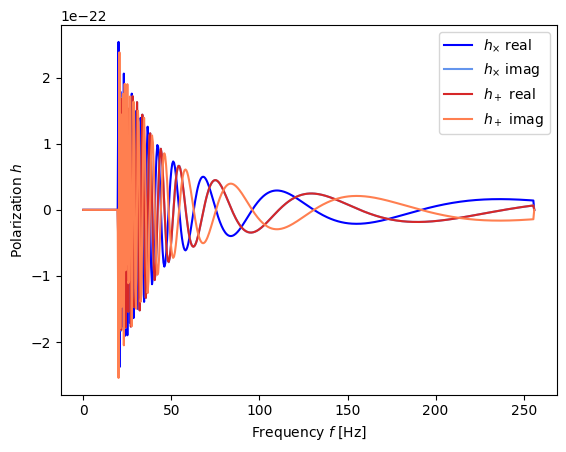

In [8]:
# Plot an exemplary waveform
f_domain = wfd.domain.sample_frequencies
data_sample = wfd[0]['waveform']

plt.plot(f_domain, data_sample['h_cross'].real, c="blue", label=r'$h_{\times}$ real')
plt.plot(f_domain, data_sample['h_cross'].imag, c="cornflowerblue", label=r'$h_{\times}$ imag')
plt.plot(f_domain, data_sample['h_plus'].real, c="tab:red", label=r'$h_+$ real')
plt.plot(f_domain, data_sample['h_plus'].imag, c="coral", label=r'$h_+$ imag')
plt.xlabel(r"Frequency $f$ [Hz]")
plt.ylabel(r"Polarization $h$")
plt.legend();


As an exmple for what you can do with DINGO, we apply a time-shift to the data point:

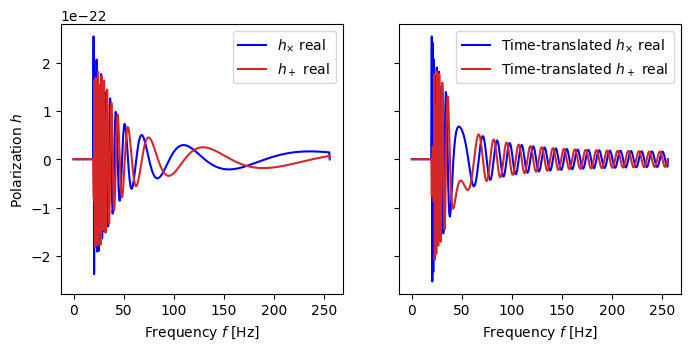

In [9]:
# Convert dictionary into numpy array
data_sample_np = np.array([data_sample['h_cross'], data_sample['h_plus']])

# Time-translate sample
time_translated_sample = wfd.domain.time_translate_data(data_sample_np, dt=0.1)

# Plot
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8,3.5))
axs[0].plot(f_domain, data_sample['h_cross'].real, c='blue', label=r'$h_{\times}$ real')
axs[0].plot(f_domain, data_sample['h_plus'].real, c='tab:red', label=r'$h_+$ real')
axs[0].set_xlabel(r"Frequency $f$ [Hz]")
axs[0].set_ylabel(r"Polarization $h$")
axs[0].legend()

axs[1].plot(f_domain, time_translated_sample[0].real, c="blue", label=r'Time-translated $h_{\times}$ real')
axs[1].plot(f_domain, time_translated_sample[1].real, c="tab:red", label=r'Time-translated $h_+$ real')
axs[1].set_xlabel(r"Frequency $f$ [Hz]")
axs[1].legend();

## 2. Generating an ASD dataset
**Step 1: Prepare settings file**

To generate the ASD dataset, we need to prepare a settings file which contains the following information within `dataset_settings`:
- **f_min, f_max** (Optional)
- **f_s**: Sampling rate. This should be at least twice the value of `f_max` expected to be used.
- **time_psd**: The entire length of data from which to estimate a PSD using Welch's method. Periodigrams are calculated on segments of this, and then averaged using the median method.
- **T**: The length of each segment on which to take the DFT and calculate a periodigram.
- **window**: Parameters of the window function used before taking DFT of data segments.
- **channels** (Optional): Channels where to download the data from. By default will use open data from GWOSC
- **time_gap**: This sets the time that is skipped between consecutive PSD estimates. If set < 0., the time segments overlap.
- **num_psds_max**: If this is set to 0, all available PSDs will be downloaded. For values > 0, a subset of all available PSDs is used.
- **detectors**: This list specifies for which detectors we want to download ASDs. Options: H1, L1, V1.
- **observing_run**: This sets the observing run of the ASDs. Options: O1, O2, O3.

In a DINGO training run where the initial layers of the embedding network are seeded with SVD components, it is necessary to generate two ASD datasets: One with a single, fiducial ASD that is fixed during the first training stage, and a second one with all ASDs of the selected observing run. In this tutorial, we will train the network with a single ASD.

More information about the noise modeling with DINGO can be found in the section [Detector Noise](https://dingo-gw.readthedocs.io/en/latest/noise_dataset.html) of the documentation. It also includes examples for `htcondor` settings that allow to run this step on the cluster.

In [10]:
asd_dataset_settings = """
dataset_settings:
#  f_min: 0         # defaults to 0
#  f_max: 2048      # defaults to f_s/2
  f_s: 4096
  time_psd: 1024
  T: 2.0
  window:
    roll_off: 0.4
    type: tukey
  time_gap: 0 # specifies the time skipped between to consecutive PSD estimates. If set < 0, the time segments overlap
  num_psds_max: 1 # if set > 0, only a subset of all available PSDs will be used
  detectors:
    - H1
    - L1
  observing_run: O1
"""
asd_dataset_settings = yaml.safe_load(asd_dataset_settings)
with open('01_training_data/asd_dataset/asd_dataset_settings.yaml', 'w') as outfile:
    yaml.dump(asd_dataset_settings, outfile, default_flow_style=False)

**Step 2: Generate ASD dataset**

If we execute the command `dingo_generate_asd_dataset` with the following arguments, it would automatically download the first valid ASD time segment of the selected observing run. (For O1, this is 1126073529 - 1126074553.)

In [11]:
!dingo_generate_asd_dataset \
--settings_file 01_training_data/asd_dataset/asd_dataset_settings.yaml \
--data_dir 01_training_data/asd_dataset --out_name 01_training_data/asd_dataset/asd_fiducial_O1.hdf5

Saving dataset to 01_training_data/asd_dataset/tmp/O1/H1/asd_1126073529.hdf5
Saving dataset to 01_training_data/asd_dataset/tmp/O1/L1/asd_1126072156.hdf5
Loading dataset from 01_training_data/asd_dataset/tmp/O1/H1/asd_1126073529.hdf5.
Loading dataset from 01_training_data/asd_dataset/tmp/O1/L1/asd_1126072156.hdf5.
Merging single dataset files into one...
Merging 1 datasets into one for detector H1.
Merging 1 datasets into one for detector L1.
Saving dataset to 01_training_data/asd_dataset/asd_fiducial_O1.hdf5


However, we are interested in analyzing GW150914. Therefore, we specify the start and end time of this event in `time_segment.pkl` and provide it as an additional argument to `dingo_generate_asd_dataset`:

In [12]:
time_GW150914 = 1126259462.391 - 0.0114 # maxlog geocent time of GW150914
asd_start_time = time_GW150914 - asd_dataset_settings["dataset_settings"]["T"]
asd_end_time = time_GW150914
time_segments = {
    'H1': [[asd_start_time, asd_end_time]],
    'L1': [[asd_start_time, asd_end_time]]
}

with open('01_training_data/asd_dataset/time_segment_GW150914.pkl', 'wb') as f:
    pickle.dump(time_segments, f)

In [13]:
!dingo_generate_asd_dataset \
--settings_file 01_training_data/asd_dataset/asd_dataset_settings.yaml \
--data_dir 01_training_data/asd_dataset --out_name 01_training_data/asd_dataset/asd_GW150914.hdf5 \
--time_segments_file 01_training_data/asd_dataset/time_segment_GW150914.pkl

Saving dataset to 01_training_data/asd_dataset/tmp/O1/H1/asd_1126259460.3796.hdf5
Saving dataset to 01_training_data/asd_dataset/tmp/O1/L1/asd_1126259460.3796.hdf5
Loading dataset from 01_training_data/asd_dataset/tmp/O1/H1/asd_1126259460.3796.hdf5.
Loading dataset from 01_training_data/asd_dataset/tmp/O1/L1/asd_1126259460.3796.hdf5.
Merging single dataset files into one...
Merging 1 datasets into one for detector H1.
Merging 1 datasets into one for detector L1.
Saving dataset to 01_training_data/asd_dataset/asd_GW150914.hdf5


Load and visualize exemplary ASD:

Loading dataset from 01_training_data/asd_dataset/asd_GW150914.hdf5.
One Datapoint contains: dict_keys(['H1', 'L1'])


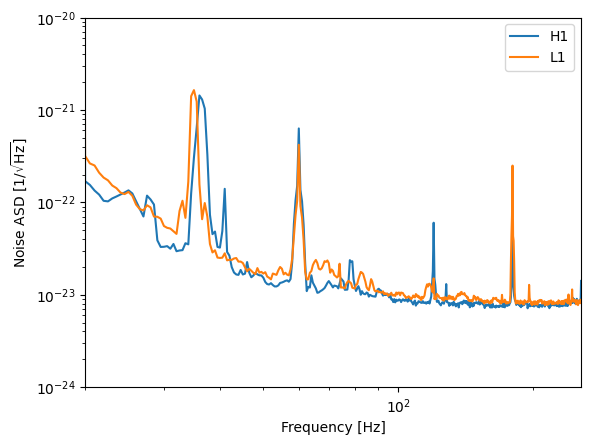

In [14]:
from dingo.gw.noise.asd_dataset import ASDDataset

# Load ASD dataset
asd_dataset_path = '01_training_data/asd_dataset/asd_GW150914.hdf5'
asds = ASDDataset(file_name=asd_dataset_path, domain_update=wfd.domain.domain_dict)
# Get ASD sample
asd_sample = asds.sample_random_asds()
print("One Datapoint contains:", asd_sample.keys())

plt.loglog(f_domain, asd_sample['H1'][0, :], label=r'H1')
plt.loglog(f_domain, asd_sample['L1'][0, :], label=r'L1')
plt.xlabel(r"Frequency [Hz]")
plt.ylabel(r"Noise ASD $[1/\sqrt{\mathrm{Hz}}]$")
plt.xlim([wfd.domain.f_min, wfd.domain.f_max])
plt.ylim([1.e-24, 1.e-20])
plt.legend();

## 3. Training a simple model
**Step 1: Prepare training config file**

The train settings file contains multiple categories:

**(a) data**: Information about training data.
- **waveform_dataset_path**: Path to the waveform dataset which contains the intrinsic waveforms
- **train_fraction**: Fraction of waveform dataset to be used for training. The remainder are used to compute the test loss.
- **window**: Defines the window function to use when FFTing the time-domain data. It is used here to calculate a window factor for simulating data. See discussion [here](https://dingo-gw.readthedocs.io/en/latest/noise_dataset.html#ref-window-factor).
- **detectors**: List of detectors that should be used during training. Options: H1, L1, V1. Note: Dingo models are trained for a *fixed set of detectors*. This must be selected prior to training, and a new model must be trained if one wishes to analyze data in a different set of detectors. Thus, e.g., separate models must be trained for HL and HLV configurations.
- **extrinsic_prior**: Specify the extrinsic prior. Default options are available.
- **ref_time**: Reference time for the interferometer locations and orientations. See the important note [here](https://dingo-gw.readthedocs.io/en/latest/training_transforms.html#ref-ref-time).
- **inference_parameters**: Parameters to infer with the model. At present they must be a subset of `sample["parameters"]`. By specifying a strict subset, this can be used to marginalize over parameters. The default setting points to `dingo.gw.prior.default_inference_parameters`.

In [15]:
from dingo.gw.prior import default_inference_parameters
default_inference_parameters

['chirp_mass',
 'mass_ratio',
 'phase',
 'a_1',
 'a_2',
 'tilt_1',
 'tilt_2',
 'phi_12',
 'phi_jl',
 'theta_jn',
 'luminosity_distance',
 'geocent_time',
 'ra',
 'dec',
 'psi']


**(b) model**: Details about the DINGO model.
- **type**: Type of model, usually: `nsf+embedding`
- **nsf_kwargs**: Kwargs of the `nsf` such as number of subsequent flow steps, kwargs of flow transform `base_transform_kwargs`.
- **embedding_net_kwargs**: Kwargs of the embedding network that compresses the data to a vector which is provided as a condition to the normalizing flow. E.g. dimension of output vector `out_dim`, hidden dimensions `hidden_dims`, how to obtain the SVD components for the initialization of the first layer `svd`.

**(c) training**: Settings for the training procedure, divided into stages. Each stage contains:
- **epochs**: Number of epochs
- **asd_dataset_path**: Path to the ASD dataset. If the DINGO model is trained in two stages, this should just contain a single fiducial ASD per detector for the first stage and a full ASD dataset per detector for the second stage.
- **freeze_rb_layer**: Whether to freeze the reduced basis layer in the embedding network in this stage.
- **optimizer**: Optimizer setings.
- **scheduler**: Scheduler settings.
- **batch_size**: Number of data points to use per batch.


**(d) local**: Technical settings (no influence on final model).
- **device**: Which device to train on. Options: `cpu`, `cuda` for training on GPU.
- **num_workers**: Number of workers that are used to preprocess the data before training. (`num_workers >0` does not work on Mac, see [post](https://stackoverflow.com/questions/64772335/pytorch-w-parallelnative-cpp206))
- **runtime_limits**: Specifies the maximum time per run and the maximum number of epochs per run.
- **checkpoint_epochs**: Sets after how many epochs a checkpoint is saved.

For more information about which default values should be used for production, please refer to the tutorials for [training an NPE model](https://dingo-gw.readthedocs.io/en/latest/example_npe_model.html), [training a GNPE model](https://dingo-gw.readthedocs.io/en/latest/example_gnpe_model.html). Furthermore, the documentation contains more details about the [network architecture](https://dingo-gw.readthedocs.io/en/latest/network_architecture.html) as well as the [training procedure](https://dingo-gw.readthedocs.io/en/latest/training.html).

Since we want to infer the posterior masses of GW150914, we fix the extrinsic prior values to the maximum likelihood values of the infered parameters.

In [16]:
train_settings = """
data:
  waveform_dataset_path: 01_training_data/waveform_dataset/waveform_dataset.hdf5  # Contains intrinsic waveforms
  train_fraction: 0.95
  window:  # Needed to calculate window factor for simulated data
    type: tukey
    f_s: 4096
    T: 2.0
    roll_off: 0.4
  detectors:
    - H1
    - L1
  extrinsic_prior:  # Sampled at train time
    dec: bilby.core.prior.analytical.DeltaFunction(-1.2616009712219238)
    ra: bilby.core.prior.analytical.DeltaFunction(1.4557750225067139)
    geocent_time: bilby.core.prior.analytical.DeltaFunction(0.011423417367041111)
    psi: bilby.core.prior.analytical.DeltaFunction(1.2124483585357666)
    luminosity_distance: bilby.core.prior.analytical.DeltaFunction(488.2327880859375)
  ref_time: 1126259462.391
  inference_parameters:
  - chirp_mass
  - mass_ratio

# Model architecture
model:
  # kwargs for neural spline flow
  posterior_model_type: normalizing_flow
  posterior_kwargs:
    num_flow_steps: 5 # 30
    base_transform_kwargs:
      hidden_dim: 64 # 1024
      num_transform_blocks: 5
      activation: elu
      dropout_probability: 0.0
      batch_norm: True
      num_bins: 8
      base_transform_type: rq-coupling
  # kwargs for embedding net
  embedding_kwargs:
    output_dim: 64 # 128
    hidden_dims: [1024, 512, 256, 64]
    activation: elu
    dropout: 0.0
    batch_norm: True
    svd:
      num_training_samples: 1000
      num_validation_samples: 100
      size: 50

# The first stage (and only) stage of training.
training:
  stage_0:
    epochs: 15
    asd_dataset_path: 01_training_data/asd_dataset/asd_GW150914.hdf5
    freeze_rb_layer: True
    optimizer:
      type: adam
      lr: 0.0001
    scheduler:
      type: cosine
      T_max: 15
    batch_size: 64
  # stage_1:
  #   epochs: 5
  #   asd_dataset_path: 01_training_data/asd_dataset/asd_GW150914.hdf5
  #   freeze_rb_layer: False
  #   optimizer:
  #     type: adam
  #     lr: 1.e-5
  #   scheduler:
  #     type: cosine
  #     T_max: 5
  #   batch_size: 64

# Local settings for training that have no impact on the final trained network.
local:
  device: cuda  # [cpu, cuda] Set this to 'cuda' for training on a GPU.
  num_workers: 2 # 6  # num_workers >0 does not work on Mac, see https://stackoverflow.com/questions/64772335/pytorch-w-parallelnative-cpp206
  runtime_limits:
    max_time_per_run: 36000
    max_epochs_per_run: 30
  checkpoint_epochs: 15
"""
train_settings = yaml.safe_load(train_settings)
with open('02_training/train_settings.yaml', 'w') as outfile:
    yaml.dump(train_settings, outfile, default_flow_style=False)

**Step 2: Start training run.**

You can start the training by executing the following command. Note that a lot of helpful information is printed during training. This includes information about the SVD initialization (e.g. the truncation of the SVD basis and the resulting mismatch), how the new model is initialized, the number of fixed and learnable parameters of the model, the epoch number with training and validation loss, etc.

Training for 20 epochs takes approximately 10 - 15 minutes.

In [17]:
!dingo_train \
--settings_file 02_training/train_settings.yaml \
--train_dir 02_training

Beginning new training run.
Loading dataset from 01_training_data/waveform_dataset/waveform_dataset.hdf5.

Building SVD for initialization of embedding network.
Setting train transforms.
Omitting 
	AddWhiteNoiseComplex
	RepackageStrainsAndASDS
	SelectStandardizeRepackageParameters
	UnpackDict
Loading dataset from 01_training_data/asd_dataset/asd_GW150914.hdf5.
Calculating new parameter standardizations.
Generating waveforms for embedding network SVD initialization.
...done. This took 1 s.
Generating SVD basis for ifo:
...H1 done.
...L1 done.
...this took 0 s.
Testing SVD basis matrices.
...H1:
n = 50
  Mean mismatch = 3.886814314846276e-11
  Standard deviation = 1.4700702428385975e-10
  Max mismatch = 1.4871011089212516e-09
  Median mismatch = 1.812966443637265e-11
  Percentiles:
    99    -> 1.5054021695882349e-10
    99.9  -> 1.3534450197250223e-09
    99.99 -> 1.4737355000016057e-09
Saving dataset to 02_training/svd_H1.hdf5
...L1:
n = 50
  Mean mismatch = 3.8538875424265486e-11
  St

The loss values are stored in the `history.txt` file which contains as columns: epoch number, training loss, validation loss, and learning rate.

We can load this file and plot the training and validation loss:

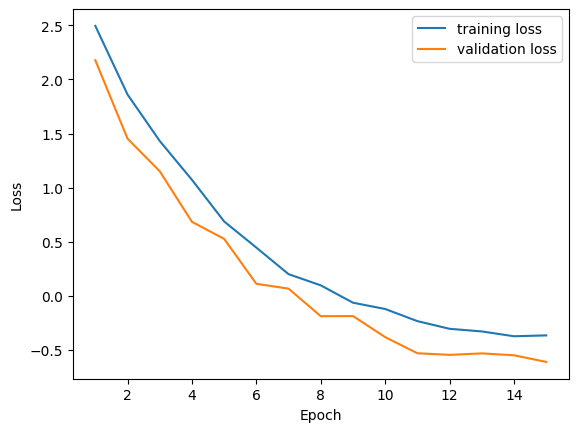

In [18]:
# Load history.txt
filename = '02_training/history.txt'
data = np.loadtxt(filename, delimiter="\t")

# Plot loss values
plt.plot(data[:,0], data[:,1], label=f"training loss")
plt.plot(data[:,0], data[:,2], label=f"validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend();

## 4. Injections

By running [inference on an injection](https://dingo-gw.readthedocs.io/en/latest/example_injection.html) consistent with what the network was trained on, and then running the trained `dingo` model on it, we can get a first understanding of its performance.

We use the **Sampler API** to prepare and run an injection:
1. Load the model `dingo.core.models.posterior_model.PosteriorModel` into the `dingo.gw.inference.gw_samplers.GWSampler` class.
2. Instantiate the `dingo.gw.injection.Injection` based on the settings the posterior model was trained on (accessible via `PosteriorModel.metadata`).
3. Specify an ASD dataset, e.g. the fiducial ASD dataset the network was trained on.
4. Sample from the prior and generate an injection.
5. Insert the generated injection data into the sampler through `sampler.context`.
6. Generate samples and convert the sampler instance into a `dingo.gw.result.Result`.
7. Run importance sampling on the result object.
8. Visualize the corner plot and save the result.

In [21]:
from dingo.core.posterior_models.normalizing_flow import NormalizingFlowPosteriorModel
from dingo.gw.inference.gw_samplers import GWSampler
from dingo.gw.injection import Injection

Putting posterior model to device cuda.
Setting spin_conversion_phase = 0.0. Using this value for the phase parameter for conversion to cartesian spins.
Loading dataset from 01_training_data/asd_dataset/asd_GW150914.hdf5.
Running sampler to generate 10000 samples.
Adding fixed parameter a_1 = 0.925635814666748 from prior.
Adding fixed parameter a_2 = 0.5538952350616455 from prior.
Adding fixed parameter geocent_time = 0.011423417367041111 from prior.
Adding fixed parameter luminosity_distance = 488.2327880859375 from prior.
Adding fixed parameter phase = 0.9604566579018894 from prior.
Adding fixed parameter phi_jl = 5.561878204345703 from prior.
Adding fixed parameter theta_jn = 2.624497413635254 from prior.
Adding fixed parameter tilt_1 = 2.0111560821533203 from prior.
Adding fixed parameter tilt_2 = 1.0743615627288818 from prior.
Adding fixed parameter dec = -1.2616009712219238 from prior.
Adding fixed parameter ra = 1.4557750225067139 from prior.
Adding fixed parameter psi = 1.21244

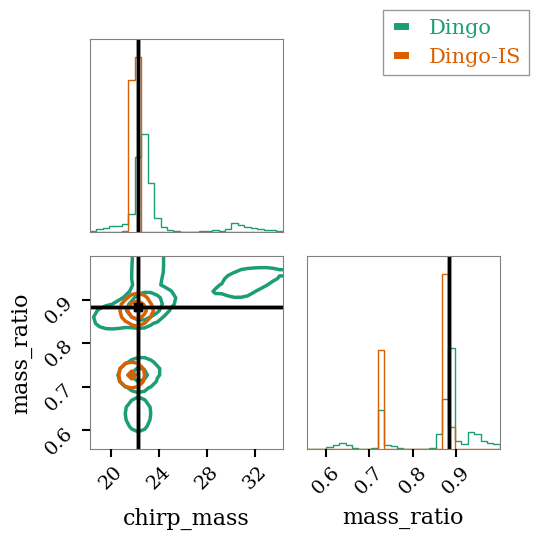

In [23]:
model_path = "02_training/model_latest.pt"
asd_path = "01_training_data/asd_dataset/asd_GW150914.hdf5"

# Load the network into the GWSampler class
pm = NormalizingFlowPosteriorModel(model_filename=model_path, device="cuda")
sampler = GWSampler(model=pm)

# Generate an injection consistent with the data the model was trained on.
injection = Injection.from_posterior_model_metadata(pm.metadata)
injection.asd = ASDDataset(asd_path, ifos=["H1", "L1"])
theta = injection.prior.sample()
inj = injection.injection(theta)

# Generate 10,000 samples from the DINGO model based on the generated injection data.
sampler.context = inj
sampler.run_sampler(10_000)
result = sampler.to_result()

# The following are only needed for importance-sampling the result.
result.importance_sample(num_processes=8)

# Make a corner plot and save the result.
result.print_summary()
kwargs = {"legend_font_size": 15, "truth_color": "black"}
result.plot_corner(parameters=["chirp_mass", "mass_ratio"],
                   filename="03_inference/injection/corner.pdf",
                   truths=theta,
                   **kwargs)
result.to_file("03_inference/injection/result.hdf5")

The officially reported values are: chirp mass $\mathcal{M}_c = 27.6^{+2.0}_{-2.0} M_{⊙}$, and mass ratio $q = 0.82^{+0.17}_{-0.20}$ (from [GWOSC](https://gwosc.org/events/GW150914/#P150914), [arXiV:1602.03837](https://arxiv.org/abs/1602.03837)).
Since we trained the model in a simplified setting (small waveform dataset, small model, short training), we don't expect high sample efficiencies (> 1%).

## 5. Real events with `dingo_pipe`

Dingo includes a command-line tool [`dingo_pipe`](https://dingo-gw.readthedocs.io/en/latest/dingo_pipe.html) for automating inference tasks. This is based very closely on the [`bilby_pipe`](https://lscsoft.docs.ligo.org/bilby_pipe/master/user-interface.html) package, with suitable modifications.

**Step 1: Prepare `.ini` file for `dingo_pipe`.**
Similar to `bilby_pipe`, `dingo_pipe` requires an `.ini` file as an input that specifies the arguments of the subsequently performed steps.
1. **Job submission arguments**: Specify cluster and system specific details here.
2. **Sampler arguments**: Determine which model should be used to generate the samples.
3. **Data generation arguments**: Define which event data should be downloaded.
4. **Plotting arguments**: Specify which plots should be generated automatically.

In [24]:
dingo_pipe_GW150914 = """
################################################################################
##  Job submission arguments
################################################################################

local = True
submit = False
accounting = dingo
request-cpus-importance-sampling = 2
simple-submission = False

################################################################################
##  Sampler arguments
################################################################################

model = 02_training/model_latest.pt
device = cuda
num-samples = 5000
batch-size = 5000
recover-log-prob = true
importance-sampling-settings = {}

################################################################################
## Data generation arguments
################################################################################

trigger-time = 1126259462.3885767 # GW150914 # condition network on maxlog geocent time 1126259462.4 - 0.011423417367041111
label = GW150914
outdir = 03_inference/outdir_GW150914
channel-dict = {H1:GWOSC, L1:GWOSC}
psd-length = 128
# sampling-frequency = 2048.0
# importance-sampling-updates = {'duration': 4.0}

################################################################################
## Plotting arguments
################################################################################

plot-corner = true
plot-weights = true
plot-log-probs = true
"""
with open('03_inference/GW150914.ini', 'w') as outfile:
    outfile.write(dingo_pipe_GW150914)

**Step 2: Run `dingo_pipe` for GW150914**

If `local=True`, you can run all steps of `dingo_pipe` automatically by executing the following command:

In [25]:
!dingo_pipe 03_inference/GW150914.ini

14:48 dingo_pipe INFO    : Loading dingo model from 02_training/model_latest.pt in order to access settings.
14:48 dingo_pipe INFO    : Setting analysis request_cpus_importance_sampling = 2
14:48 dingo_pipe INFO    : PSD duration set to 256.0s, 128x the duration 2.0s
14:48 dingo_pipe INFO    : Setting segment trigger-times [1126259462.3885767]
14:48 dingo_pipe INFO    : Skipping datafind for H1 as GWOSC data is used.
14:48 dingo_pipe INFO    : Skipping datafind for L1 as GWOSC data is used.
14:48 dingo_pipe INFO    : Running command: /work/nihargupte/environments/micromamba/envs/dingo-asimov/bin/dingo_pipe_generation 03_inference/outdir_GW150914/GW150914_config_complete.ini --label GW150914_data0_1126259462-3885767_generation --idx 0 --trigger-time 1126259462.3885767 --outdir 03_inference/outdir_GW150914
14:48 dingo_pipe INFO    : Command line arguments: Namespace(ini='03_inference/outdir_GW150914/GW150914_config_complete.ini', verbose=False, calibration_model=None, calibration_correct

This script produces several files in the folder `03_inference/outdir_GW150914`, where `results` contains the generated (importance) samples, and different plots. Similar to the injections, we don't expect good results from this simplified toy setting.

**Exercises**:
1. Replace the delta function over the luminosity distance in the prior of the DINGO model by a Uniform distribution over $d_L \in [100, 1000]$ Mpc.
2. Train a marginalized model & perform inference.
3. Train a model that infers the luminosity distance as well.

You can use the folder `04_exercise` and its subfolders to save the settings files and models.

# 6. Inference with a pre-trained DINGO model (from Zenodo)

After illustrating all steps at a toy example, the rest of the tutorial will focus on running inference with a pretrained `dingo` model that can be downloaded from Zenodo. These production models rely on the algorithm ["Group Equivariant Neural Posterior Estimation" (GNPE)](https://dingo-gw.readthedocs.io/en/latest/gnpe.html) which includes (approximate) joint symmetries of data and parameters in the `dingo` model and simplifies the data subject to time shifts.

Practically, this introduces only one change:
Instead of one `dingo` model, we have to deal with two separate models:
1. **Initialization model**: This model learns a proxy for the arrival times of the signal in each detector and acts as a starting point for the Gibbs sampler. Based on the output of this model, the strain data is transformed and simplified before serving as an input to the main model.
2. **Main model**: This network is conditioned on the proxy variable and learns the full posterior distribution.


**Step 1: Download trained DINGO model from Zenodo**

We start by downloading the O1 GNPE networks from Zenodo (see [here](https://zenodo.org/records/12156303)). They were trained with `IMRPhenomXPHM`, and a luminosity distance prior of $d_L \in [100 - 1000]$ Mpc.




In [26]:
!wget -q --directory-prefix=05_pretrained_model/init_train_dir https://zenodo.org/records/12156303/files/model_init.pt # init model
!wget -q --directory-prefix=05_pretrained_model/main_train_dir https://zenodo.org/records/12156303/files/model.pt # main model

**Step 2: Create compatible .ini file**

Since we are now working with a GNPE model, the `GW150914.ini` file has to be adapted. We need to specify the path to the initial as well as the main model and need to include the argument `num_gnpe_iterations` which determines the number of Gibbs sampling iterations.

We set `recover-log-prob = False` and `importance-sample = False`, to speed up execution for the tutorial. If you change these values to `True`, the log probability values have to be recovered for importance sampling with GNPE which takes more time.

In [ ]:
dingo_pipe_GW150914 = """
################################################################################
##  Job submission arguments
################################################################################

local = True
submit = False
accounting = dingo
request-cpus-importance-sampling = 2
simple-submission = False

################################################################################
##  Sampler arguments
################################################################################

model-init = 05_pretrained_model/init_train_dir/model_init.pt
model = 05_pretrained_model/main_train_dir/model.pt
device = cuda
num-gnpe-iterations = 5 #30
num-samples = 5000
batch-size = 5000
recover-log-prob = False
prior-dict = {
luminosity_distance = bilby.gw.prior.UniformComovingVolume(minimum=100, maximum=2000, name='luminosity_distance'),
}
importance-sample = False

################################################################################
## Data generation arguments
################################################################################

trigger-time = GW150914
label = GW150914
outdir = 05_pretrained_model/outdir_GW150914
channel-dict = {H1:GWOSC, L1:GWOSC}
psd-length = 128
# sampling-frequency = 2048.0
# importance-sampling-updates = {'duration': 4.0}

################################################################################
## Plotting arguments
################################################################################

plot-corner = true
plot-weights = true
plot-log-probs = true
"""
with open('05_pretrained_model/GW150914.ini', 'w') as outfile:
    outfile.write(dingo_pipe_GW150914)

**Step 3: Run `dingo_pipe` on pretrained DINGO model**

Finally, we can run `dingo_pipe` with the specified `.ini` file to obtain the results for the complete posterior distribution.

In [ ]:
!dingo_pipe 05_pretrained_model/GW150914.ini

The full 14-dimensional corner plot based on DINGO samples can be found in `05_pretrained_model/outdir_GW150914/results`.

**Exercises:**
1. Run an injection with the GNPE model. You can find some hints in the [GNPE](https://dingo-gw.readthedocs.io/en/latest/gnpe.html) and [injection](https://dingo-gw.readthedocs.io/en/latest/example_injection.html) docs.

You will need to use the `GNPESampler` class that can be imported via
`from dingo.core.samplers import GNPESampler`.